In [8]:
using Distributions, Random, Plots, StatsBase
path = "C:\\Users\\lucy_\\bats\\radiotrack"
include(string(path,"\\src\\StochasticSimulations.jl"))

Main.StochasticSimulations

In [9]:
N = 56
D = 65
T = 3600
dt = 200
args = (D=D,N=N,T=T,dt=dt)

sim = args |> StochasticSimulations.diffusion_simulation |> StochasticSimulations.square_distance

(MSD = [0.0 49492.9 … 9.17799e5 9.64682e5], std_error = [0.0, 7680.97, 21798.2, 44147.3, 47873.9, 53679.7, 62464.2, 68730.1, 70474.2, 64855.6, 70296.7, 95432.3, 1.22001e5, 1.29617e5, 1.51154e5, 1.75096e5, 1.74631e5, 1.71838e5])

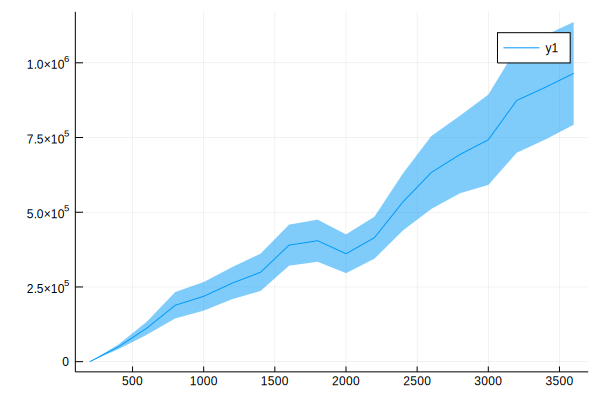

In [10]:
plot(dt:dt:T,sim.MSD',ribbon=sim.std_error)

In [61]:
function drift_step(args,x,y)
    r = sqrt.(x.^2 + y.^2)
    idx = sortperm(r)[end-args.N_scouts:end]
    xdir = x./r
    ydir = y./r
    x .= x .+ rand(Normal(0,sqrt(2*args.D*args.dt)),args.N)
    y .= y .+ rand(Normal(0,sqrt(2*args.D*args.dt)),args.N)
    x[idx] .= x[idx] .- xdir[idx].*args.chi.*args.dt.*(r[idx].^args.r_exp)
    y[idx] .= y[idx] .- ydir[idx].*args.chi.*args.dt.*(r[idx].^args.r_exp)
    return x,y 
end

function diffusion_step(args,x,y)
    """
    Takes position x,y and returns a new position after a diffusion step
    with diffusion coefficient D and timestep dt
    """
    return x .+ rand(Normal(0,sqrt(2*args.D*args.dt)),args.N), y .+ rand(Normal(0,sqrt(2*args.D*args.dt)),args.N)
end

function drift_simulation(args)
    """
    Stochastic diffusion simulation with discrete time and arguments
    args = (D=diffusion coefficient,N=number of particles,T=time of simulation,dt=timestep)
    returns positions in the trajectory.
    """
    t = args.dt:args.dt:args.T
    x = zeros(Float64,args.N,length(t))
    y = zeros(Float64,args.N,length(t))
    for (j,ts) in enumerate(t[1:end-1])
        if ts < args.TD
            x[:,j+1],y[:,j+1]=diffusion_step(args,x[:,j],y[:,j])
        else
            x[:,j+1],y[:,j+1]=drift_step(args,x[:,j],y[:,j])
        end
    end
    return (x=x,y=x)
end

drift_simulation (generic function with 1 method)

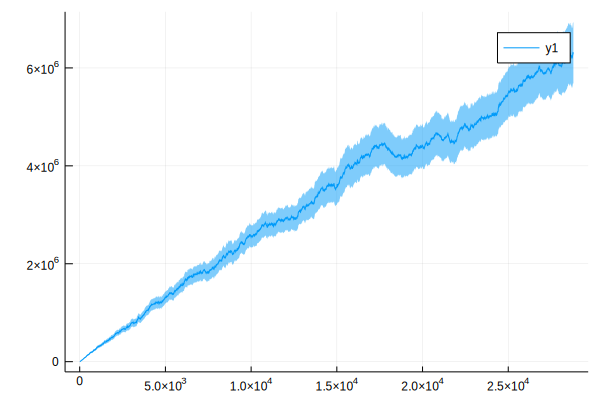

In [62]:
args = (N=200, N_scouts=10, D=D, D2=3, chi=10^5, dt=10, TD=3800, T=3600*8, r_threshold=10, r_exp=-2)

drift_sim = args |> drift_simulation |> StochasticSimulations.square_distance

plot(args.dt:args.dt:args.T,drift_sim.MSD',ribbon=drift_sim.std_error)

In [30]:


function drift_step(D,chi,dt,ts,tD,x,y,r_threshold,r_exp)
    r = sqrt(x^2+y^2)
    if r > r_threshold 
        xdir = x/sqrt(x^2+y^2)
        ydir = y/sqrt(x^2+y^2)
        return x - rand(Normal(xdir*chi*dt*(r^r_exp),sqrt(2*D*dt))), y - rand(Normal(ydir*chi*dt*(r^r_exp),sqrt(2*D*dt)))
    else
        return 0,0
    end
end


function leapfrog_sim(D1,D2,chi,t,N,N_scouts,tD,start_time,r_threshold,r_exp)
    r_threshold = 10
    x = Array{Float64}(undef,N,length(t))
    x.=0
    y = Array{Float64}(undef,N,length(t))
    y.=0
    for (j,ts) in enumerate(t[1:end-1]) 
        idx = sortperm(x[:,j].^2 + y[:,j].^2)[end-N_scouts:end]
        for i = 1:N
            if ts < tD
                x[i,j+1],y[i,j+1] = diffusion_step(D1,dt,x[i,j],y[i,j])
            elseif any(x->x==i, idx)
                x[i,j+1],y[i,j+1] = drift_step(D2,chi,dt,ts,tD,x[i,j],y[i,j],r_threshold,r_exp)
            else
                x[i,j+1],y[i,j+1] = diffusion_step(D2,dt,x[i,j],y[i,j])
            end
        end
    end
    meansd = MSD(x,y)
    return meansd
end

leapfrog_sim (generic function with 1 method)